In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as F

import numpy as np
import os
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join("/home/eccoope", "pv-vision")
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join("/home/eccoope", "el_img_cracks_ec", "scripts")

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks/retrain/"
sys.path.append(ojas_functions_dir)

from utils.unet_model import construct_unet
import functions

In [3]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"


model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

checkpoint_name = root.split("/")[-2]

In [4]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

In [5]:
def load_dataset(root):
    transformers = functions.Compose(
        [functions.ChanneledFixResize(256), functions.ToTensor(), functions.Normalize()]
    )

    train_dataset = functions.SolarDataset(
        root, image_folder="img/train", mask_folder="ann/train", transforms=transformers
    )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return train_dataset, val_dataset

In [ ]:
def load_device_and_model():
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    unet = construct_unet(len(category_mapping))
    unet = torch.nn.DataParallel(unet)

    model = unet.module.to(device)

    return device, model

In [7]:
def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    folders = [folder for folder in os.listdir(checkpoint_dir)]

    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)

    os.makedirs(new_folder_path, exist_ok=True)

    return new_folder_path

In [ ]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model()

In [9]:
import matplotlib.pyplot as plt


def new_inference_and_show(idx, threshold=0.5):
    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = train_loader.dataset.__getitem__(idx)
    img = img.to(device)

    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = train_loader.dataset.__getraw__(idx)

    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 4, H, W]
    probs = torch.sigmoid(logits)  # shape: [1, 4, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [4, H, W]

    # Ground truth is assumed to be already a 4-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [4, H, W]

    # --- Visualization ---
    # Create a grid with 3 rows and 4 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = len(category_mapping)
    class_names = [f"({k}) {v}" for k, v in category_mapping.items()]

    fig, axs = plt.subplots(3, n_classes, figsize=(4 * n_classes, 12))

    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert("L"), cmap="viridis")
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis("off")
    for j in range(1, n_classes):
        axs[0, j].axis("off")

    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap="viridis")
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis("off")

    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap="viridis")
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis("off")

    fig.suptitle("Retrained Model Prediction", fontsize=16)

    plt.tight_layout()
    plt.show()

# Training

In [12]:
batch_size_val = 4
batch_size_train = 4
lr = 1e-4
step_size = 1
gamma = 0.1
num_epochs = 2
criterion = torch.nn.BCEWithLogitsLoss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [14]:
optimizer = Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [15]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()

        optimizer.zero_grad()

        # forward pass
        output = model(data)

        # calc loss -- bce with logits loss applies sigmoid interally
        training_loss = criterion(output, target)

        # backward pass
        training_loss.backward()
        optimizer.step()

        # record loss
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()

        # forward pass
        data = data.to(device)

        output = model(data)

        # calc loss -- bce with logits loss applies sigmoid interally
        val_loss = criterion(output, target)

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

 50%|█████     | 1/2 [03:53<03:53, 233.67s/it]

Saved model at epoch 1


100%|██████████| 2/2 [07:37<00:00, 228.67s/it]

Saved model at epoch 2


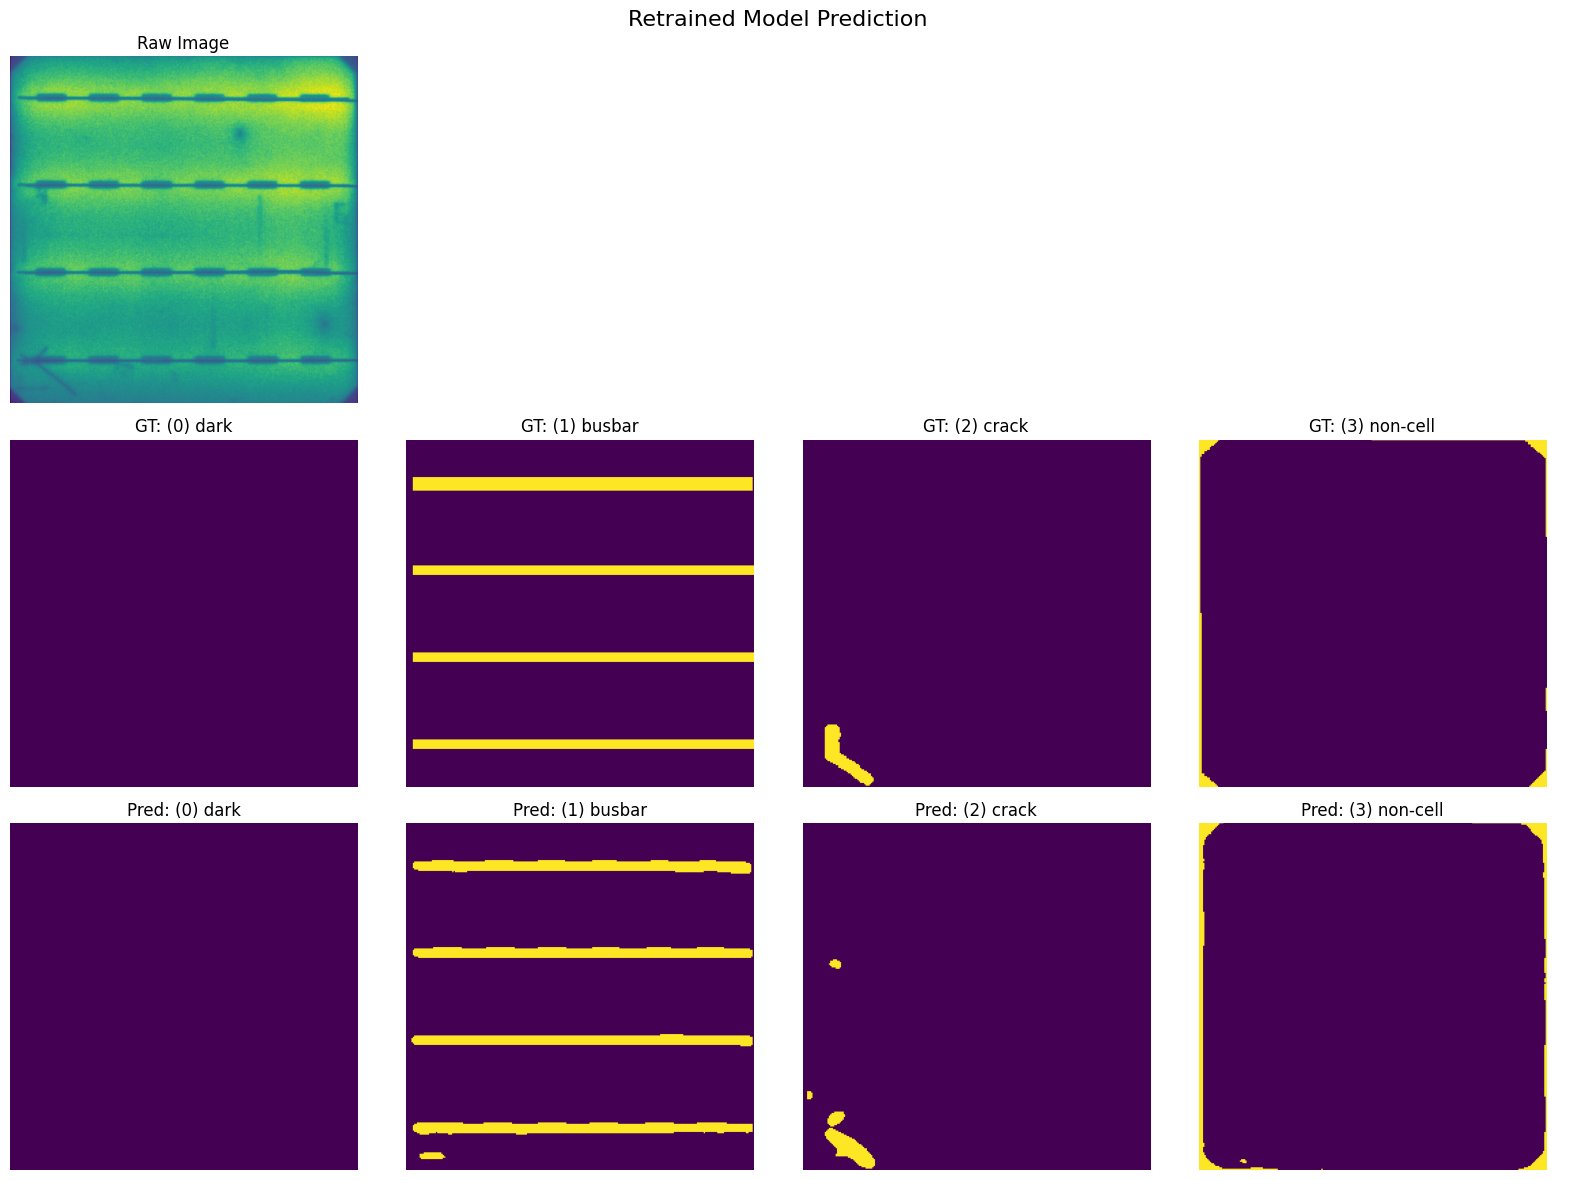

In [16]:
new_inference_and_show(-32)

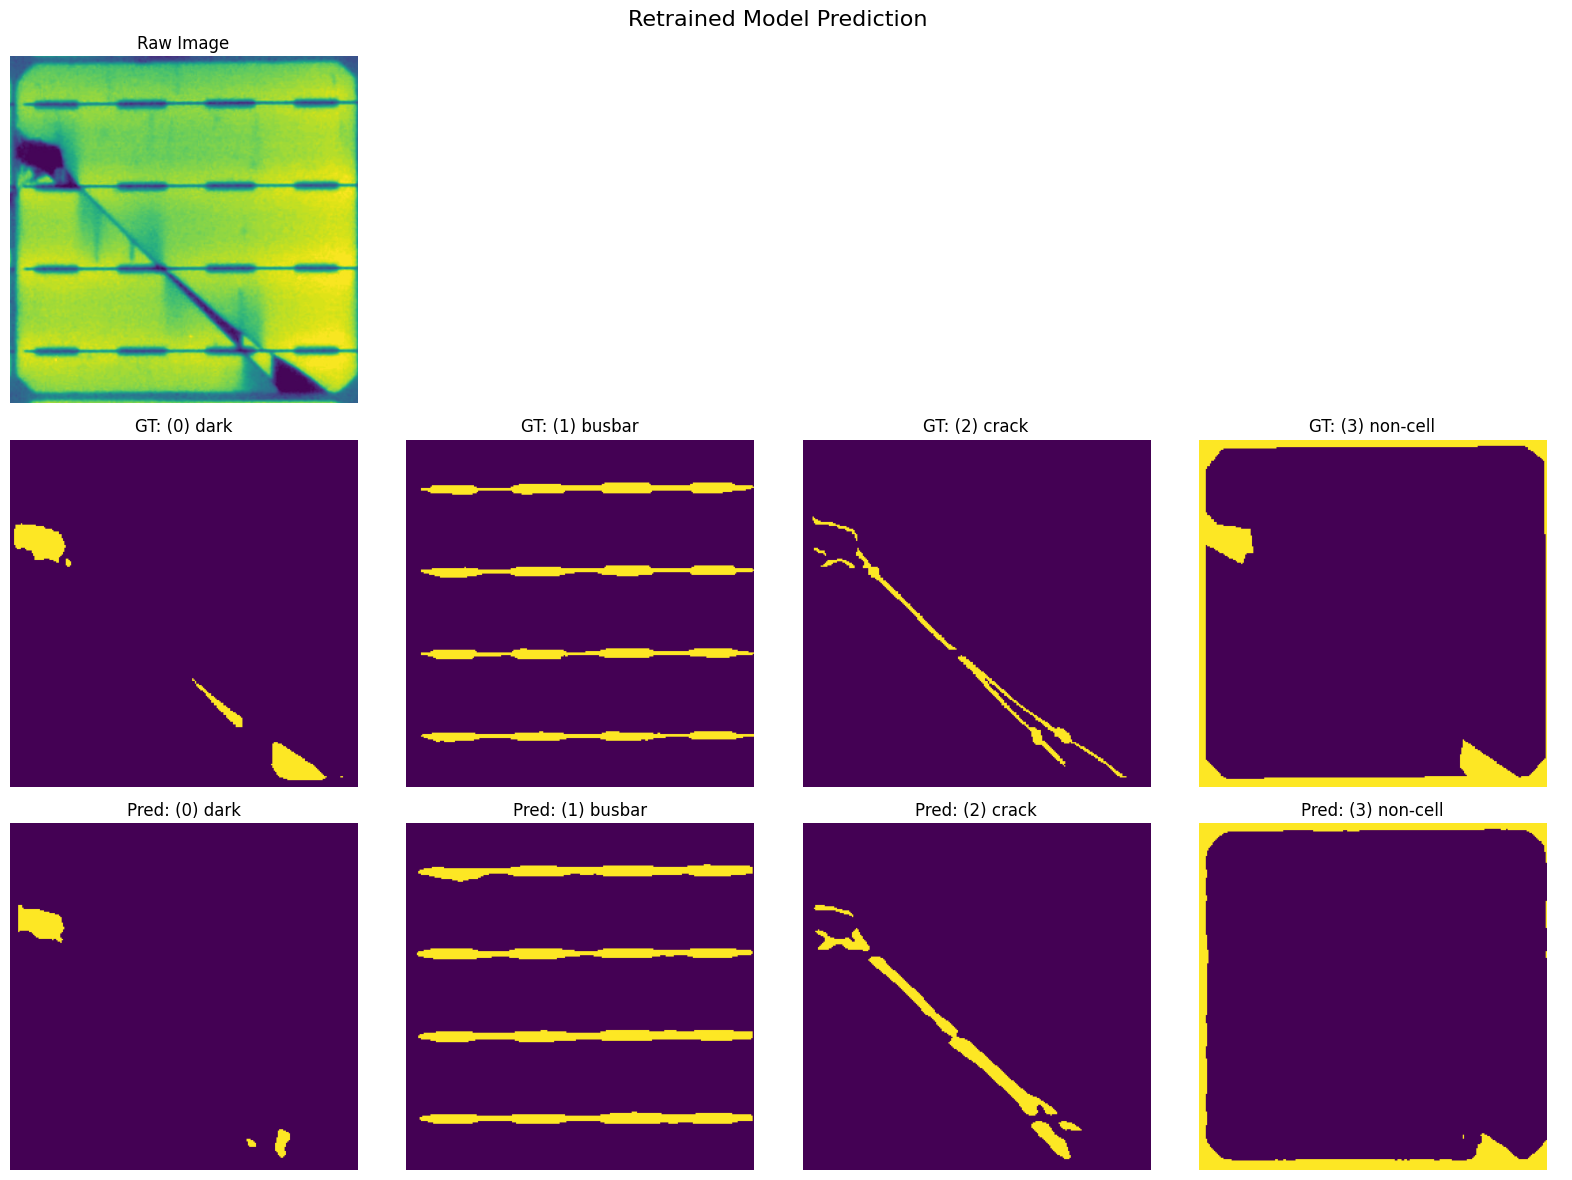

In [17]:
new_inference_and_show(13)

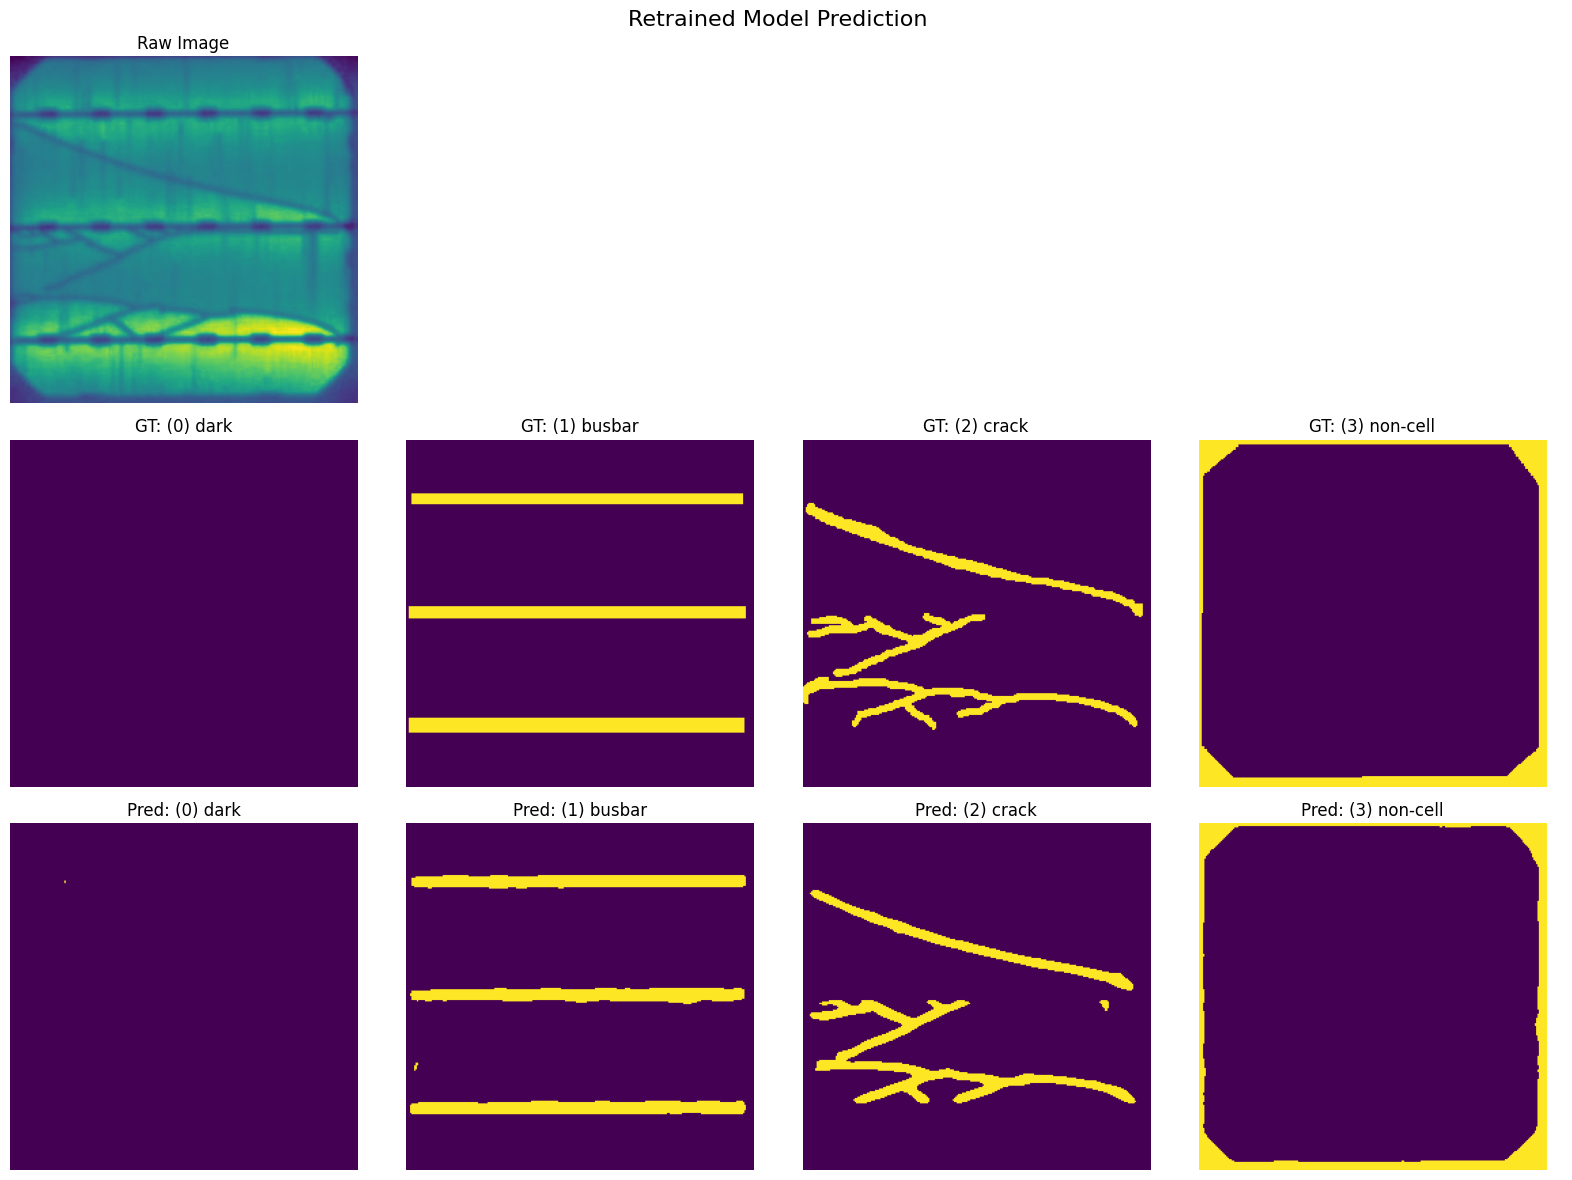

In [18]:
new_inference_and_show(44)

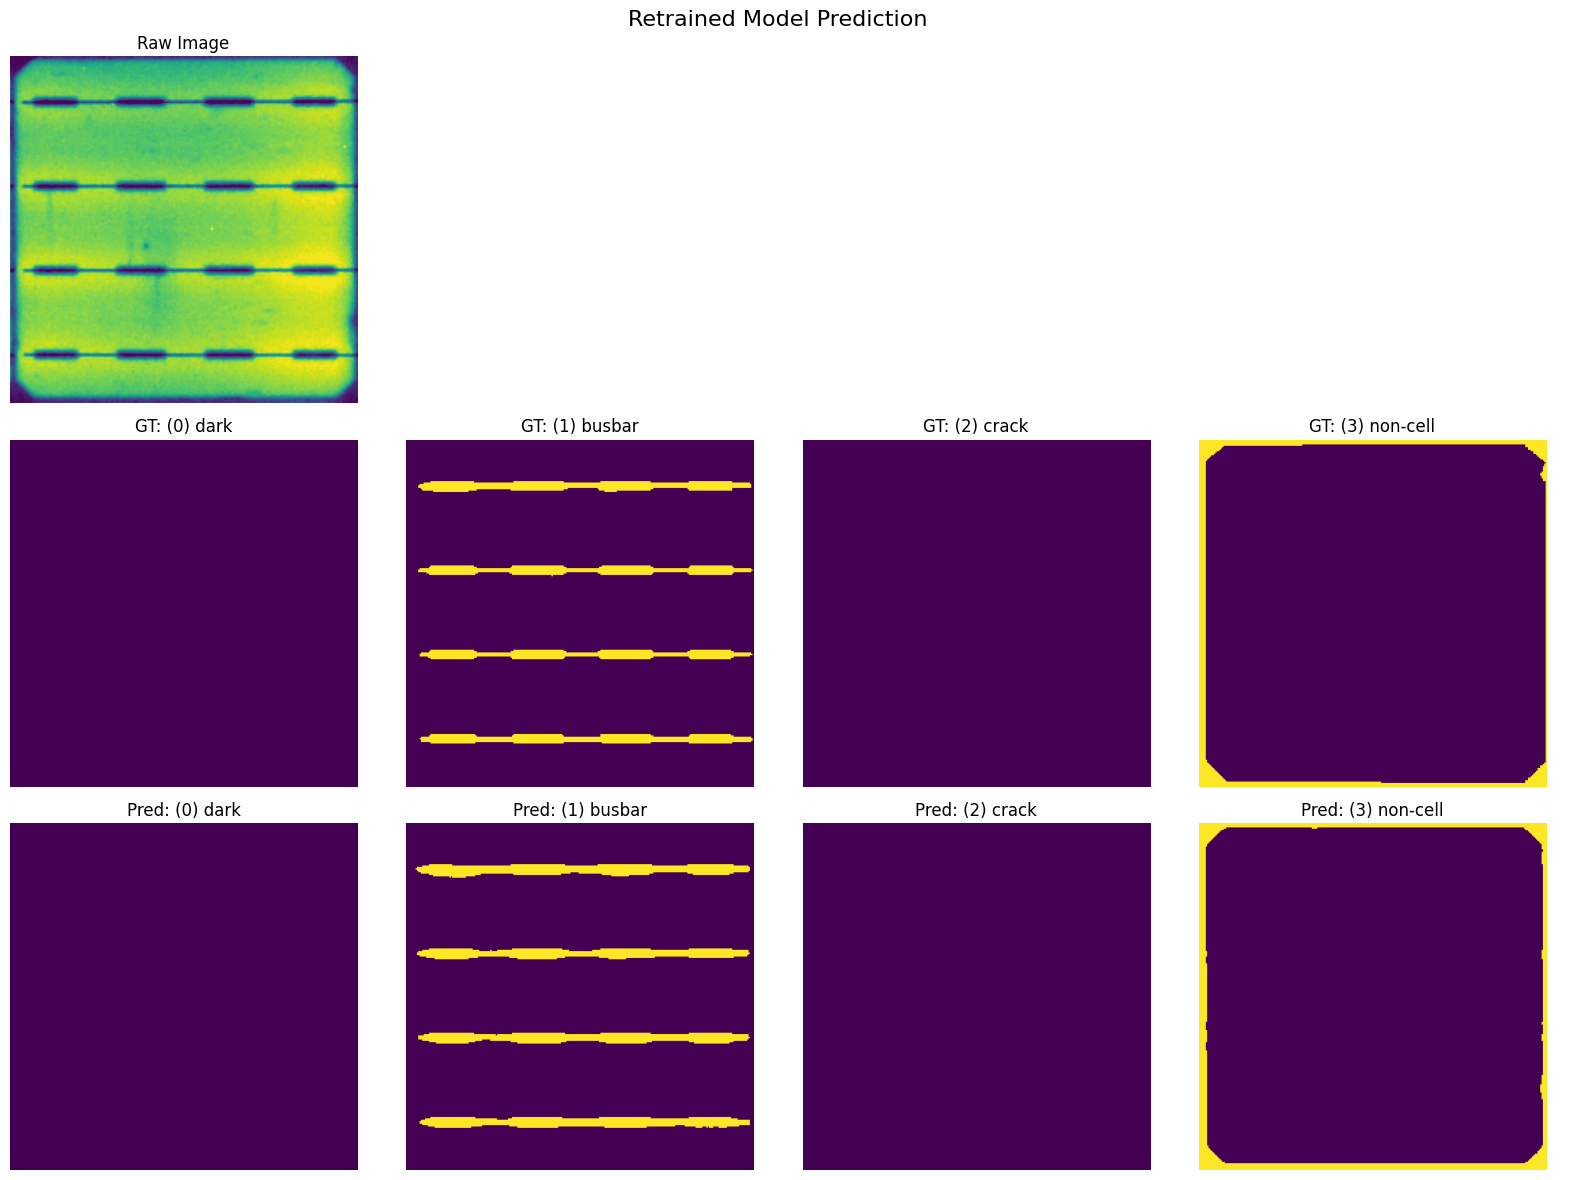

In [19]:
new_inference_and_show(1)

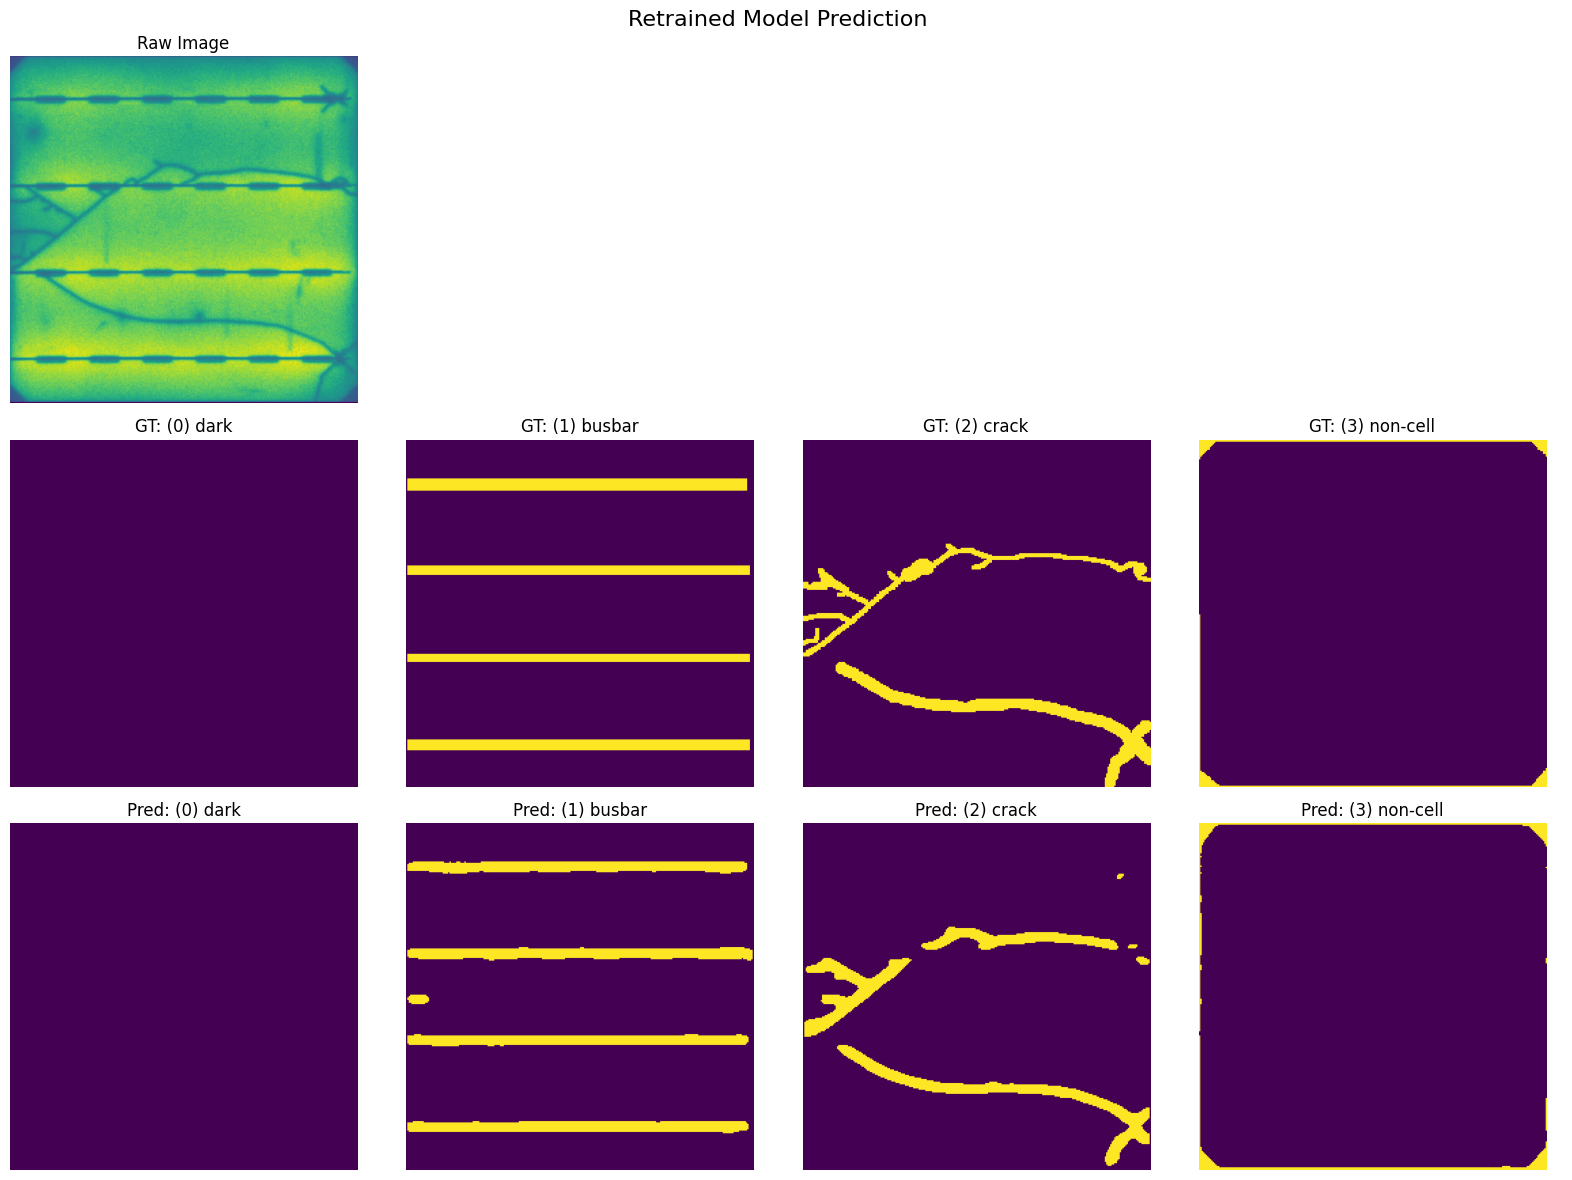

In [20]:
new_inference_and_show(6)

In [21]:
# for i in range(100):
#     new_inference_and_show(i)

[np.float64(0.34962845473191734), np.float64(0.16375334267260544)]


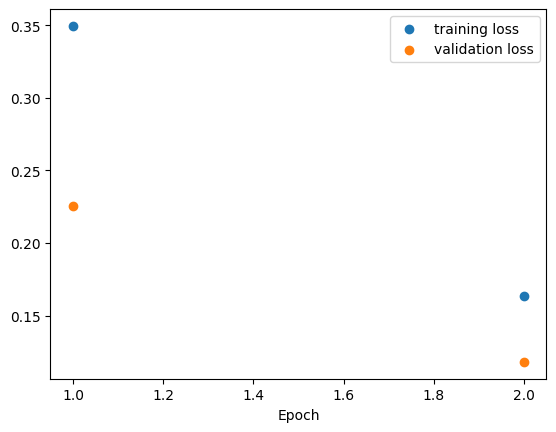

In [22]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [23]:
val_epoch_loss

[np.float64(0.22519506838451436), np.float64(0.11807221189445379)]